In [18]:
using CSV, DataFrames, TimeSeries, DataStructures, Clustering
using GraphPlot, Graphs, URIs
using StatsBase: maximum, minimum, median, mean, countmap
import PyPlot as plt
import PlotlyJS
include("../influencecascade_platform.jl")
include("../entropy.jl")
include("../tool_helper.jl")
include("../visualizations.jl");

## Load the data and format it

In [2]:
datafolder = "../../Data/Twitter/"
datafile = datafolder * "all_links_processed.json"
data = load_json(datafile)

#datafiles = [file for file in readdir(datafolder) if occursin("processed.json", file)]
#frames = [load_json(datafolder * file) for file in datafiles]
#data = vcat(frames...)

#=
data = CSV.read(datafiles[1], DataFrame, header=1, types=String)

#new_row = DataFrame(id = "0006", author_id = "6", username = "?Cyril06", created_at = "2021-10-31T00:09:04.000Z", lang = "en", text = "test climate change", original_text = "test climate change",
#    hashtags = missing, category = "['tweeted']", URLs = "['https://www.cnn.com/test']", domain = "['cnn']", domain_suffix = "['com']", country = missing, country_code = missing, sentiment = "neutral")
#append!(data, new_row);

function str_to_vec(string)
    if ismissing(string)
        return missing
    end
    # remove `[]` characters at beginning and end, and split based on commas following a quote char
    list = split(string[2:end-1], "', ")
    res = []
    for str in list
        if first(str) == '\'' && last(str) == '\''
            push!(res, String(collect(str)[2:end-1]))
        elseif first(str) == '\''
            push!(res, String(collect(str)[2:end]))
        elseif last(str) == '\''
            push!(res, String(collect(str)[1:end-1]))
        end
    end
    return res
end

data."hashtags" = data."hashtags" .|> str_to_vec
data."category" = data."category" .|> str_to_vec
data."URLs" = data."URLs" .|> str_to_vec
data."domain" = data."domain" .|> str_to_vec
data."domain_suffix" = data."domain_suffix" .|> str_to_vec

=#

data = data[.~ismissing.(data."urls"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

## Define the partition, actors and actions

In [8]:
part_fun = sentiment
actor_fun = follower_count
action_fun = trust_popularity_score_v2

cuttoff = 0.5
et = "Any Edge"
part = "neutral"

clean_dates = x -> floor(x, Dates.Hour(2));
data.time = clean_dates.(data."created_at");

df = data |> part_fun |> action_fun |> actor_fun |> x -> sort(x, :time);

## Compute influence graph

In [19]:

tsg = TimeSeriesGenerator(:actor, :action, :partition)
time_series = observe(df, tsg);

#ig = InfluenceGrapher(unique(df[!, tsg.action_col]))
#influence_graph = observe(time_series, ig);

In [11]:

tsg = TimeSeriesGenerator(:actor, :action, :partition)
time_series2 = observe_v2(df, tsg);

ig = InfluenceGrapher(unique(df[!, tsg.action_col]))
influence_graph2 = observe_v2(time_series2, ig);


In [12]:
influence_graph == influence_graph2

true

In [16]:
for m in 1:length(influence_graph)
    for i = 1:size(influence_graph[1])[1], j = 1:size(influence_graph[1])[1]
        for k = 1:4, l = 1:4
            if influence_graph[m][i,j][k,l] != influence_graph2[m][i,j][k,l]
                print("false")
            end
        end
    end
end

In [17]:
function to_matrix(ts)
    out = Vector{Vector{Matrix{Int}}}(undef, length(ts))
    for i in 1:length(ts)
        a = Vector{Matrix}(undef, length(ts[i]))
        for j in 1:length(ts[i])
            b = Matrix(undef, size(ts[i][j])...)
            for (k, col) in enumerate(colnames(ts[i][j]))
                b[:, k] = Int.(values(ts[i][j][col]))
            end
            a[j] = b
        end
        out[i] = a
    end
    return out
end

time_series = to_matrix(time_series) 

for i in 1:length(time_series)
    for j = 1:length(time_series[i])
        for k = 1:size(time_series[i][j])[1], l = 1:size(time_series[i][j])[2]
            if time_series[i][j][k,l] != time_series2[i][j][k,l]
            end
        end
    end
end

## Compte influence cascade and plot influence graph

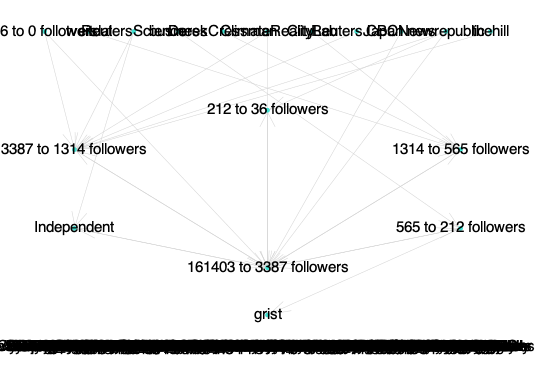

In [41]:
begin
	function make_simplifier(edge_type)
		if edge_type=="Any Edge"
			return x->(maximum(x)>cuttoff)
		else
			idx = findfirst(x->(x==et), edgeTypes)
			return x->(x[idx]>cuttoff)
		end
	end
	s = make_simplifier(et)

	icg = InfluenceCascadeGenerator(cuttoff)
	influence_cascades = observe.(influence_graph, Ref(icg))
	all_ics = vcat(influence_cascades...)

	
	partitions = unique(df[!,tsg.part_col])
	i = (1:length(partitions))[findfirst(x->x==part, partitions)]
	xs, ys, influencers = influence_layout(influence_graph[i]; simplifier=s)
	g = print_graph(influence_graph[i]; simplifier=s)

	# In this case we plot the graph on a world map
	if actor_fun == country
		PlotlyJS.plot(map_plot(df)...)
	# In this case we plot a simple graph of the actors
	else
		gplot(g, xs, ys, nodelabel=unique(df.actor))
	end
	
end

In [60]:
infl = unique(df.actor)[influencers]
influencer_node1 = infl[1]
influencer_node2 = infl[1]

PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[findfirst(x->x==part,unique(df[!, tsg.part_col]))][findfirst(x->x==influencer_node1, unique(df[!, tsg.actor_col])[influencers])],
	unique(df[!, tsg.action_col]))...)

data: [
  "sankey with fields arrangement, link, node, type, and valueformat"
]

layout: "layout with fields font, margin, template, and title"

In [80]:
PlotlyJS.savefig(PlotlyJS.plot(plot_cascade_sankey(
	influence_cascades[2][4], unique(df[!, tsg.action_col]))...), "sankey.png")

"sankey.png"

In [57]:
a.write_image("test.pdf")

LoadError: MethodError: objects of type Dict{Any, Any} are not callable

PyPlot.Figure(PyObject <Figure size 800x800 with 3 Axes>)

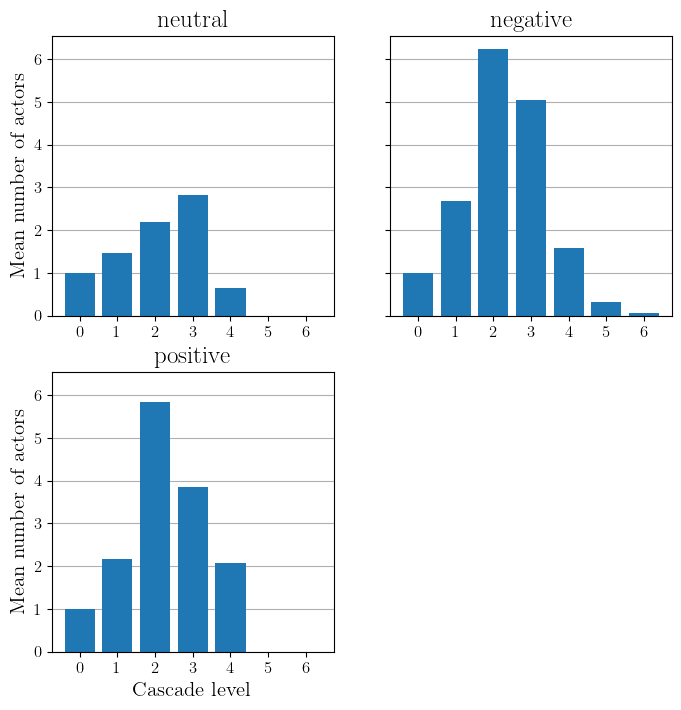

In [54]:
show(plot_actors_per_level(influence_cascades, df, save=true, filename="ic.pdf"))

In [51]:
plot_actor_wordcloud(df, Nactor=300, save=true, filename="wordcloud.svg")

mask size: 600×800, content area: 615² (36²/word)
set fontsize ∈ [8.0, 300]
set density = 0.5
⋯scale=39.7015427911813, density=0.5765178394410653	↑
⋯scale=36.973112362798425, density=0.5206083411976494	↑
⋯scale=35.91516398543256, density=0.49923725386012363	↓
fontsize ∈ [8.0, 39.58483122189838]
175 words(58%) are limited to the minimum font size.
gathering style: rt = 1, ellipse
gathering style: rt = 1, ellipse
▸1. scale = 28.762766776513924


┌ Info: nepoch: 1000, patient: 10
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:482


12 epochs


┌ Info: @epoch 9(+2), 10(1) collisions, reposition [107] to [(579, 191)]
└ @ Stuffing.Trainer /Users/cyrilvallez/.julia/packages/Stuffing/oYQwL/src/fit.jl:494


PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

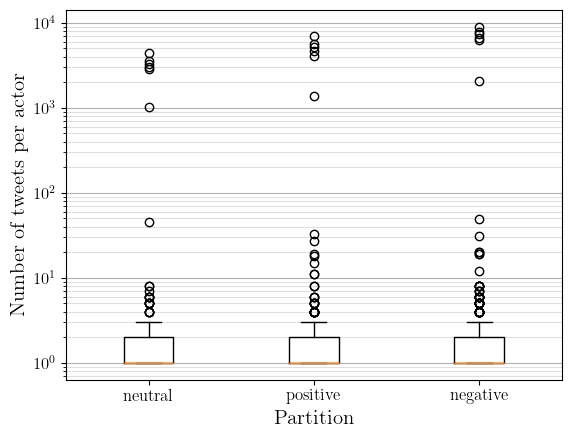

In [52]:
show(plot_actor_frequency(df, save=true, filename="boxplot.pdf"))

PyPlot.Figure(PyObject <Figure size 800x800 with 3 Axes>)

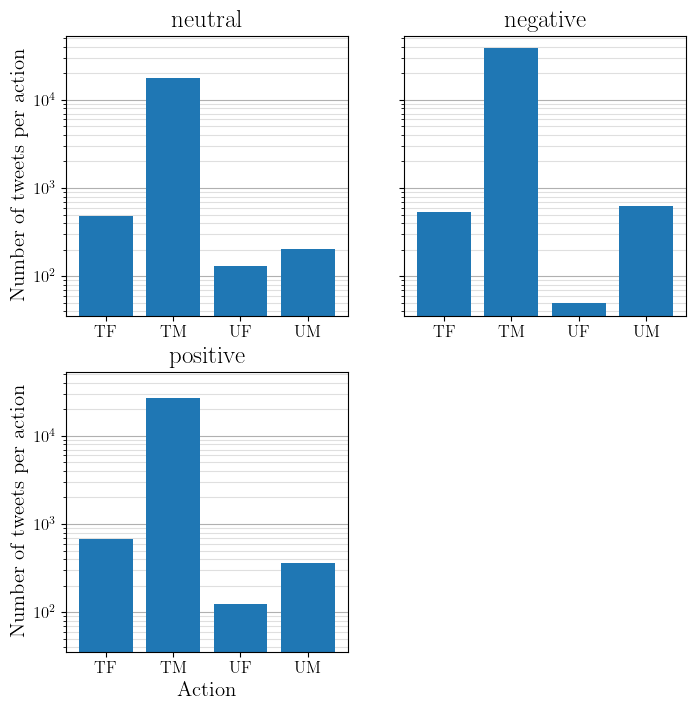

In [53]:
include("../visualizations.jl");
show(plot_action_frequency(df, split_by_partition = true, save=true, filename="actions.pdf"))

In [50]:
include("../visualizations.jl");
show(plot_action_frequency_v2(df, split_by_partition = true))

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/cyrilvallez/.julia/packages/PyCall/ygXW2/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (4,).')
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/pyplot.py", line 2355, in bar
    return gca().bar(
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/__init__.py", line 1423, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/matplotlib/axes/_axes.py", line 2383, in bar
    x, height, width, y, linewidth, hatch = np.broadcast_arrays(
  File "<__array_function__ internals>", line 180, in broadcast_arrays
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 540, in broadcast_arrays
    shape = _broadcast_shape(*args)
  File "/Users/cyrilvallez/.julia/conda/3/lib/python3.10/site-packages/numpy/lib/stride_tricks.py", line 422, in _broadcast_shape
    b = np.broadcast(*args[:32])
